In [1]:

from functools import partial
from pathlib import Path
import numpy as np
import lnoi400
import gdsfactory as gf
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), "../../scripts/")))
import devices
import components

gf.clear_cache()

def to_itype(points, dbu):
    return [(int(round(x / dbu)), int(round(y / dbu))) for x, y in points]
dbu = 0.001

@gf.cell
def chip_frame():
    c = gf.get_component("chip_frame", size=(10_000, 5000), center=(5050, 2525))
    return c

chip_layout = chip_frame()

input_ext = 10.0
double_taper = gf.get_component("double_linear_inverse_taper",input_ext=input_ext,)

routing_roc = 50.0
ports_gap = 50
frame = 50

trav_wave_eom = devices.tWave_EOM()

n = 0

device_xoffset = 180.0 + frame
device_yoffset = 160.0 + frame
in_port_xoffset = 100
out_port_xoffset = -70 

x_in = frame + in_port_xoffset
in_loc = np.array([x_in, 0])
out_loc = np.array([x_in + device_xoffset + trav_wave_eom.dxsize + out_port_xoffset, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0.0, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def trave_wave_eom_circuit(
    trav_wave_eom = trav_wave_eom,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    trav_wave_eom_ref = c << trav_wave_eom
    trav_wave_eom_ref.dmovex(- trav_wave_eom_ref.ports["o1"].dcenter[0] + device_xoffset)
    trav_wave_eom_ref.dmovey(chip_layout.dymax - trav_wave_eom_ref.dymax - device_yoffset)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        trav_wave_eom_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        trav_wave_eom_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        trav_wave_eom_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

circuit = trave_wave_eom_circuit()

######################################

######################################

routing_xoffset = 0.04 # percentage of the horizontal size of a device
routing_yoffset = 0.50

eom_ec_emmi = devices.dOR_EOM_DC_EMMI()

n = 1

device_xoffset = 180.0 + frame
device_yoffset = 130.0 + frame + eom_ec_emmi.dysize
in_port_xoffset = 100 + n * ports_gap
out_port_xoffset = -70 + ports_gap

x_in = frame + in_port_xoffset
in_loc = np.array([x_in, 0])
out_loc = np.array([x_in + device_xoffset + trav_wave_eom.dxsize + out_port_xoffset, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0.0, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def eom_ec_emmi_circuit2(
    eom_ec_emmi = eom_ec_emmi,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    eom_ec_emmi_ref = c << eom_ec_emmi
    eom_ec_emmi_ref.dmovex(- eom_ec_emmi_ref.ports["o1"].dcenter[0] + 2 * device_xoffset)
    eom_ec_emmi_ref.dmovey(chip_layout.dymax - eom_ec_emmi_ref.dysize - 0.6 * device_yoffset)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 5)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 2.5),
                   (ecs["out2"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 2.5)]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

ni = 2
no = 2
device_xoffset = 180.0 + frame
device_yoffset = 130.0 + frame + eom_ec_emmi.dysize
in_port_xoffset = 100 + ni * ports_gap
out_port_xoffset = -70 + no * ports_gap

x_in = frame + in_port_xoffset
in_loc = np.array([x_in, 0])
out_loc = np.array([x_in + device_xoffset + trav_wave_eom.dxsize + out_port_xoffset, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0.0, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def eom_ec_emmi_circuit3(
    eom_ec_emmi = eom_ec_emmi,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    eom_ec_emmi_ref = c << eom_ec_emmi
    eom_ec_emmi_ref.dmovex(- eom_ec_emmi_ref.ports["o1"].dcenter[0] + eom_ec_emmi_ref.dxsize + 3 * device_xoffset)
    eom_ec_emmi_ref.dmovey(chip_layout.dymax - eom_ec_emmi_ref.dysize - 0.6 * device_yoffset)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o1"].dcenter[0] - routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o1"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o1"].dcenter[0]- routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o1"].dcenter[1] - routing_yoffset * eom_ec_emmi_ref.dysize),
                   (ecs["in"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o1"].dcenter[1] - routing_yoffset * eom_ec_emmi_ref.dysize)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 7),
                   (ecs["out1"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 7)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 9.5),
                   (ecs["out2"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 9.5)]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

ni = 3
no = 3
device_xoffset = 180.0 + frame
device_yoffset = 130.0 + frame + eom_ec_emmi.dysize
in_port_xoffset = 100 + ni * ports_gap
out_port_xoffset = -70 + no *  ports_gap

x_in = frame + in_port_xoffset
in_loc = np.array([x_in, 0])
out_loc = np.array([x_in + device_xoffset + trav_wave_eom.dxsize + out_port_xoffset, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0.0, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)


ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def eom_ec_emmi_circuit4(
    eom_ec_emmi = eom_ec_emmi,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    eom_ec_emmi_ref = c << eom_ec_emmi
    eom_ec_emmi_ref.dmovex(- eom_ec_emmi_ref.ports["o1"].dcenter[0] + 2 * device_xoffset)
    eom_ec_emmi_ref.dmovey(chip_layout.dymax - eom_ec_emmi_ref.dysize - 1.4 * device_yoffset)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 5)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 2.5),
                   (ecs["out2"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 2.5)]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

ni = 4
no = 4
device_xoffset = 180.0 + frame
device_yoffset = 130.0 + frame + eom_ec_emmi.dysize
in_port_xoffset = 100 + ni * ports_gap
out_port_xoffset = -70 + no * ports_gap

x_in = frame + in_port_xoffset
in_loc = np.array([x_in, 0])
out_loc = np.array([x_in + device_xoffset + trav_wave_eom.dxsize + out_port_xoffset, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0.0, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def eom_ec_emmi_circuit5(
    eom_ec_emmi = eom_ec_emmi,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    eom_ec_emmi_ref = c << eom_ec_emmi
    eom_ec_emmi_ref.dmovex(- eom_ec_emmi_ref.ports["o1"].dcenter[0] + eom_ec_emmi_ref.dxsize + 3 * device_xoffset)
    eom_ec_emmi_ref.dmovey(chip_layout.dymax - eom_ec_emmi_ref.dysize - 1.4 * device_yoffset)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o1"].dcenter[0] - routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o1"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o1"].dcenter[0]- routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o1"].dcenter[1] - routing_yoffset * eom_ec_emmi_ref.dysize),
                   (ecs["in"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o1"].dcenter[1] - routing_yoffset * eom_ec_emmi_ref.dysize)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 5)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 2.5),
                   (ecs["out2"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 2.5)]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c



####################################

####################################

routing_xoffset = 0.04 # percentage of the horizontal size of a device
routing_yoffset = 0.50

eom_ec_emmi = devices.dOR_EOM_DC_EMMI(
    lextra = 205/2,
    ls = 3850
)

n = 5

device_xoffset = 180.0 + frame
device_yoffset = 130.0 + frame + eom_ec_emmi.dysize
in_port_xoffset = 100 + n * ports_gap
out_port_xoffset = -70 + n * ports_gap

x_in = frame + in_port_xoffset
in_loc = np.array([x_in, 0])
out_loc = np.array([x_in + device_xoffset + trav_wave_eom.dxsize + out_port_xoffset, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0.0, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def eom_ec_emmi_circuit6(
    eom_ec_emmi = eom_ec_emmi,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    eom_ec_emmi_ref = c << eom_ec_emmi
    eom_ec_emmi_ref.dmovex(- eom_ec_emmi_ref.ports["o1"].dcenter[0] + 2.1 * device_xoffset)
    eom_ec_emmi_ref.dmovey(chip_layout.dymax - 3 * eom_ec_emmi_ref.dysize - 0.7 * device_yoffset)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 5)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 2.5),
                   (ecs["out2"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize + 2.5)]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

eom_ec_emmi = devices.dOR_EOM_DC_EMMI(
    lextra = 205/2,
    ls = 3850
)

n = 6

device_xoffset = 180.0 + frame
device_yoffset = 130.0 + frame + eom_ec_emmi.dysize
in_port_xoffset = 100 + n * ports_gap
out_port_xoffset = -70 + n * ports_gap

x_in = frame + in_port_xoffset
in_loc = np.array([x_in, 0])
out_loc = np.array([x_in + device_xoffset + trav_wave_eom.dxsize + out_port_xoffset, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0.0, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def eom_ec_emmi_circuit7(
    eom_ec_emmi = eom_ec_emmi,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    eom_ec_emmi_ref = c << eom_ec_emmi
    eom_ec_emmi_ref.dmovex(- eom_ec_emmi_ref.ports["o1"].dcenter[0] + 2.1 * device_xoffset + ports_gap)
    eom_ec_emmi_ref.dmovey(chip_layout.dymax - 4 * eom_ec_emmi_ref.dysize - 0.7 * device_yoffset)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 7 + 1 * eom_ec_emmi_ref.dysize),
                   (ecs["out1"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 7 + 1 * eom_ec_emmi_ref.dysize)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 9.5 + 1 * eom_ec_emmi_ref.dysize),
                   (ecs["out2"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 9.5 + 1 * eom_ec_emmi_ref.dysize)]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

eom_ec_emmi = devices.dOR_EOM_DC_EMMI(
    lextra = 205/2,
    ls = 3850
)

n = 7

device_xoffset = 180.0 + frame
device_yoffset = 130.0 + frame + eom_ec_emmi.dysize
in_port_xoffset = 100 + n * ports_gap
out_port_xoffset = -70 + n * ports_gap

x_in = frame + in_port_xoffset
in_loc = np.array([x_in, 0])
out_loc = np.array([x_in + device_xoffset + trav_wave_eom.dxsize + out_port_xoffset, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0.0, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def eom_ec_emmi_circuit8(
    eom_ec_emmi = eom_ec_emmi,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    eom_ec_emmi_ref = c << eom_ec_emmi
    eom_ec_emmi_ref.dmovex(- eom_ec_emmi_ref.ports["o1"].dcenter[0] + 2.1 * device_xoffset + 2 * ports_gap)
    eom_ec_emmi_ref.dmovey(chip_layout.dymax - 5 * eom_ec_emmi_ref.dysize - 0.7 * device_yoffset)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o2"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize, eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 19 + 2 * eom_ec_emmi_ref.dysize),
                   (ecs["out1"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o2"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 19 + 2 * eom_ec_emmi_ref.dysize)]
    )

    gf.routing.route_single(
        c,
        eom_ec_emmi_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1]),
                   (eom_ec_emmi_ref.ports["o3"].dcenter[0] + routing_xoffset * eom_ec_emmi_ref.dxsize + 6, eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 21.5 + 2 * eom_ec_emmi_ref.dysize),
                   (ecs["out2"].ports["o2"].dcenter[0], eom_ec_emmi_ref.ports["o3"].dcenter[1] + routing_yoffset * eom_ec_emmi_ref.dysize - 21.5 + 2 * eom_ec_emmi_ref.dysize)]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

(598.953, 17.0)
2025-05-30 17:12:06.661 | ERROR    | kfactory.kcell:dup:706 - When duplicating a Cell, avoid giving the duplicate the same name, as this can cause naming conflicts and may render the GDS/OASIS file unwritable. If you're using a @cell function, ensure that the function has a different name than the one being called.


2025-05-30 17:12:07.549 | ERROR    | kfactory.kcell:name:631 - Name conflict in kfactory.kcell::name at line 631
Renaming Unnamed_343 (cell_index=343) to tofabstruct would cause it to be named the same as:
 - tofabstruct (cell_index=342), function_name=None, basename=None
2025-05-30 17:12:07.649 | ERROR    | kfactory.kcell:name:631 - Name conflict in kfactory.kcell::name at line 631
Renaming Unnamed_380 (cell_index=380) to tofabstruct would cause it to be named the same as:
 - tofabstruct (cell_index=342), function_name=None, basename=None
 - tofabstruct (cell_index=343), function_name=None, basename=None
2025-05-30 17:12:07.664 | ERROR    | kfactory.kcell:name:631 - Name conflict in kfactory.kcell::name at line 631
Renaming Unnamed_381 (cell_index=381) to tofabstruct would cause it to be named the same as:
 - tofabstruct (cell_index=342), function_name=None, basename=None
 - tofabstruct (cell_index=343), function_name=None, basename=None
 - tofabstruct (cell_index=380), function_name=

' _ = die.write_gds(gdsdir=Path.cwd()) '

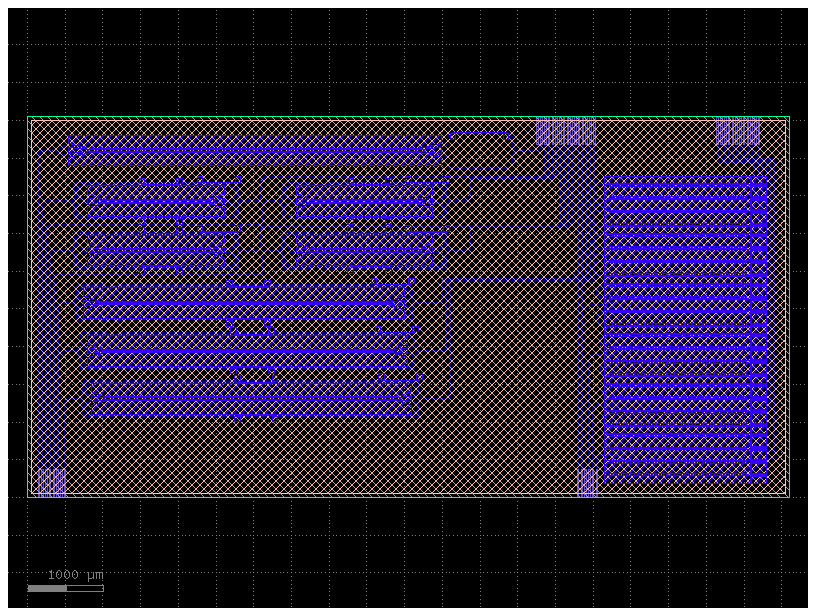

In [2]:
duel_eo_comb = devices.dualEOcomb_sbend()

n = 1

device_gap = duel_eo_comb.dysize + 100

device_xoffset2 = 250.0 + frame
device_yoffset2 = -200.0 + frame + duel_eo_comb.dysize

routing_xoffset2 = 1600
routing_yoffset2 = 600

in_port_xoffset = chip_layout.dxmax - duel_eo_comb.dxsize - device_xoffset2 + frame - 80
out_port_xoffset = chip_layout.dxmax - 1000 

x_in =  in_port_xoffset - frame - (6 - n) * ports_gap
x_out = out_port_xoffset - frame + (2 * n) * ports_gap
in_loc = np.array([x_in, 0])
out_loc = np.array([x_out, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def duel_eo_comb_circuit9(
    duel_eo_comb = duel_eo_comb,
    ecs = ecs,
    n = 1,
) -> gf.Component:

    c = gf.Component()
    duel_eo_comb_ref = c << duel_eo_comb
    duel_eo_comb_ref.dmovex(chip_layout.dxmax - duel_eo_comb_ref.ports["o1"].dcenter[0] - duel_eo_comb_ref.dxsize - device_xoffset2 )
    duel_eo_comb_ref.dmovey(chip_layout.dymax - duel_eo_comb_ref.ports["o1"].dcenter[1] - duel_eo_comb_ref.dysize - device_yoffset2 - (n - 1) * device_gap)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, duel_eo_comb_ref.ports["o2"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5)]
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n - 4), duel_eo_comb_ref.ports["o3"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4), chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4)),
                   (ecs["out2"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4))]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

duel_eo_comb = devices.dualEOcomb_sbend()

n = 2

x_in =  in_port_xoffset - frame - (6 - n) * ports_gap
x_out = out_port_xoffset - frame + (2 * n) * ports_gap
in_loc = np.array([x_in, 0])
out_loc = np.array([x_out, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def duel_eo_comb_circuit10(
    duel_eo_comb = duel_eo_comb,
    ecs = ecs,
    n = 2,
) -> gf.Component:

    c = gf.Component()
    duel_eo_comb_ref = c << duel_eo_comb
    duel_eo_comb_ref.dmovex(chip_layout.dxmax - duel_eo_comb_ref.ports["o1"].dcenter[0] - duel_eo_comb_ref.dxsize - device_xoffset2)
    duel_eo_comb_ref.dmovey(chip_layout.dymax - duel_eo_comb_ref.ports["o1"].dcenter[1] - duel_eo_comb_ref.dysize - 1 * device_yoffset2 - (n - 1) * device_gap)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, duel_eo_comb_ref.ports["o2"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5)]
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n - 4), duel_eo_comb_ref.ports["o3"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4), chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4)),
                   (ecs["out2"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4))]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

duel_eo_comb = devices.dualEOcomb_sbend()

n = 3

x_in =  in_port_xoffset - frame - (6 - n) * ports_gap
x_out = out_port_xoffset - frame + (2 * n) * ports_gap
in_loc = np.array([x_in, 0])
out_loc = np.array([x_out, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def duel_eo_comb_circuit11(
    duel_eo_comb = duel_eo_comb,
    ecs = ecs,
    n = 3,
) -> gf.Component:

    c = gf.Component()
    duel_eo_comb_ref = c << duel_eo_comb
    duel_eo_comb_ref.dmovex(chip_layout.dxmax - duel_eo_comb_ref.ports["o1"].dcenter[0] - duel_eo_comb_ref.dxsize - device_xoffset2)
    duel_eo_comb_ref.dmovey(chip_layout.dymax - duel_eo_comb_ref.ports["o1"].dcenter[1] - duel_eo_comb_ref.dysize - 1 * device_yoffset2 - (n - 1) * device_gap)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, duel_eo_comb_ref.ports["o2"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5)]
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n - 4), duel_eo_comb_ref.ports["o3"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4), chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4)),
                   (ecs["out2"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n - 4))]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

duel_eo_comb = devices.dualEOcomb_sbend()

n = 4

x_in =  in_port_xoffset - frame - (6 - n) * ports_gap
x_out = out_port_xoffset - frame + (2 * n) * ports_gap
in_loc = np.array([x_in, 0])
out_loc = np.array([x_out, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def duel_eo_comb_circuit12(
    duel_eo_comb = duel_eo_comb,
    ecs = ecs,
    n = 4,
) -> gf.Component:

    c = gf.Component()
    duel_eo_comb_ref = c << duel_eo_comb
    duel_eo_comb_ref.dmovex(chip_layout.dxmax - duel_eo_comb_ref.ports["o1"].dcenter[0] - duel_eo_comb_ref.dxsize - device_xoffset2)
    duel_eo_comb_ref.dmovey(chip_layout.dymax - duel_eo_comb_ref.ports["o1"].dcenter[1] - duel_eo_comb_ref.dysize - 1 * device_yoffset2 - (n - 1) * device_gap)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, duel_eo_comb_ref.ports["o2"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5)]
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n - 4), duel_eo_comb_ref.ports["o3"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4), chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4)),
                   (ecs["out2"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n - 4))]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

duel_eo_comb = devices.dualEOcomb_sbend()

n = 5

x_in =  in_port_xoffset - frame - (6 - n) * ports_gap
x_out = out_port_xoffset - frame + (2 * n) * ports_gap
in_loc = np.array([x_in, 0])
out_loc = np.array([x_out, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def duel_eo_comb_circuit13(
    duel_eo_comb = duel_eo_comb,
    ecs = ecs,
    n = 5,
) -> gf.Component:

    c = gf.Component()
    duel_eo_comb_ref = c << duel_eo_comb
    duel_eo_comb_ref.dmovex(chip_layout.dxmax - duel_eo_comb_ref.ports["o1"].dcenter[0] - duel_eo_comb_ref.dxsize - device_xoffset2)
    duel_eo_comb_ref.dmovey(chip_layout.dymax - duel_eo_comb_ref.ports["o1"].dcenter[1] - duel_eo_comb_ref.dysize - 1 * device_yoffset2 - (n - 1) * device_gap)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, duel_eo_comb_ref.ports["o2"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5)]
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n - 4), duel_eo_comb_ref.ports["o3"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4), chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4)),
                   (ecs["out2"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n - 4))]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c

duel_eo_comb = devices.dualEOcomb_sbend(
        #RF_res_layout_path = '/Users/gab/PICLab Dropbox/personal/gsant/LXT_MPW/combs/microwave_design/tofab_res.gds',
        #RF_pad_layout_path = '/Users/gab/PICLab Dropbox/personal/gsant/LXT_MPW/combs/microwave_design/tofab_pad_short.gds',
)

n = 6

x_in =  in_port_xoffset - frame - (6 - n) * ports_gap
x_out = out_port_xoffset - frame + (2 * n) * ports_gap
in_loc = np.array([x_in, 0])
out_loc = np.array([x_out, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc - [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out1 = gf.Component()
ec_ref = ec_out1 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [ports_gap, 0.5 * input_ext]
)
ec_out1.add_ports(ec_ref.ports)

ec_out2 = gf.Component()
ec_ref = ec_out2 << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc + [0, 0.5 * input_ext]
)
ec_out2.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out1": ec_out1,
    "out2": ec_out2,
}

@gf.cell
def duel_eo_comb_circuit14(
    duel_eo_comb = duel_eo_comb,
    ecs = ecs,
    n = 6,
) -> gf.Component:

    c = gf.Component()
    duel_eo_comb_ref = c << duel_eo_comb
    duel_eo_comb_ref.dmovex(chip_layout.dxmax - duel_eo_comb_ref.ports["o1"].dcenter[0] - duel_eo_comb_ref.dxsize - device_xoffset2)
    duel_eo_comb_ref.dmovey(chip_layout.dymax - duel_eo_comb_ref.ports["o1"].dcenter[1] - duel_eo_comb_ref.dysize - 1 * device_yoffset2 - (n - 1) * device_gap)

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=0.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o2"],
        ecs["out1"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, duel_eo_comb_ref.ports["o2"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o2"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4) + 5, chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5),
                   (ecs["out1"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4) + 5)]
    )

    gf.routing.route_single(
        c,
        duel_eo_comb_ref.ports["o3"],
        ecs["out2"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
        waypoints=[(duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n - 4), duel_eo_comb_ref.ports["o3"].dcenter[1]),
                   (duel_eo_comb_ref.ports["o3"].dcenter[0] + routing_xoffset2 + 5 * (2 * n  - 4), chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4)),
                   (ecs["out2"].ports["o2"].dcenter[0], chip_layout.dymax - routing_yoffset2 + 5 * (2 * n  - 4))]
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out1"].ports["o1"])
    c.add_port(name="o3", port=ecs["out2"].ports["o1"])

    return c


circuit2 = eom_ec_emmi_circuit2()
circuit3 = eom_ec_emmi_circuit3()
circuit4 = eom_ec_emmi_circuit4()
circuit5 = eom_ec_emmi_circuit5()
circuit6 = eom_ec_emmi_circuit6()
circuit7 = eom_ec_emmi_circuit7()
circuit8 = eom_ec_emmi_circuit8()

respath = "/Users/gab/PICLab Dropbox/personal/gsant/LXT_MPW/combs/microwave_design/tofab_res.gds"
padpath = "/Users/gab/PICLab Dropbox/personal/gsant/LXT_MPW/combs/microwave_design/tofab_pad_short.gds"
circuit9  =  duel_eo_comb_circuit9(duel_eo_comb=devices.dualEOcomb_sbend(
    ls = 1986.7,
    RF_res_layout_path = respath,
    RF_pad_layout_path = padpath,
    ))
circuit10 = duel_eo_comb_circuit10(duel_eo_comb=devices.dualEOcomb_sbend(
    ls = 1882.1,
    RF_res_layout_path = respath,
    RF_pad_layout_path = padpath,
    ))
circuit11 = duel_eo_comb_circuit11(duel_eo_comb=devices.dualEOcomb_sbend(
    ls = 1788.0,
    RF_res_layout_path = respath,
    RF_pad_layout_path = padpath,
    ))
circuit12 = duel_eo_comb_circuit12(duel_eo_comb=devices.dualEOcomb_sbend(
    ls = 1702.9,
    RF_res_layout_path = respath,
    RF_pad_layout_path = padpath,
    ))
circuit13 = duel_eo_comb_circuit13(duel_eo_comb=devices.dualEOcomb_sbend(
    ls = 1625.5,
    RF_res_layout_path = respath,
    RF_pad_layout_path = padpath,
    ))
circuit14 = duel_eo_comb_circuit14(duel_eo_comb=devices.dualEOcomb_sbend(
    ls = 1554.8,
    RF_res_layout_path = respath,
    RF_pad_layout_path = padpath,
    ))

@gf.cell
def die_assembled(
    chip_layout = chip_layout,
    circuit = circuit,
    circuit2 = circuit2,
    circuit3 = circuit3,
    circuit4 = circuit4,
    circuit5 = circuit5,
    circuit6 = circuit6,
    circuit7 = circuit7,
    circuit8 = circuit8,
    circuit9 = circuit9,
    circuit10 = circuit10,
    circuit11 = circuit11,
    circuit12 = circuit12,
    circuit13 = circuit13,
    circuit14 = circuit14

) -> gf.Component:
    c = gf.Component()
    c << chip_layout
    c << circuit
    c << circuit2
    c << circuit3
    c << circuit4
    c << circuit5
    c << circuit6
    c << circuit7
    c << circuit8
    c << circuit9
    c << circuit10
    c << circuit11
    c << circuit12
    c << circuit13
    c << circuit14

    """ c.add_ports(circuit.ports)
    c.add_ports(circuit2.ports) """
    return c

die = die_assembled()
die.plot()
die.show()
""" _ = die.write_gds(gdsdir=Path.cwd()) """



In [3]:
die.pprint_ports()

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer ┃ center ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━┩
└──────┴───────┴─────────────┴───────┴────────┴───────────┘

In [4]:
gf.clear_cache()